## Eliminating for-loops that have carry-over using `lax.scan`

In this tutirial we will see how we can eliminate for-loops that have carry-over using `lax.scan`.

From the [JAX docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html), `lax.scan` replaces a for-loop with carry-over, by "scanning" a function over leading array axes while carrying along state.

The semantics are described as follows:

    def scan(f, init, xs, length=None):
        if xs is None:
            xs = [None] * length
        carry = init
        ys = []
        for x in xs:
            carry, y = f(carry, x)  # carry is the carryover
            ys.append(y)            # the `y`s get accumulated into a stacked array
        return carry, np.stack(ys)

A key requirement of the function `f`, which is the function that gets scanned over the array `xs`, is that it must have only two positional arguments in there, one for `carry` and one for `x`. 

Let's see some concrete examples of this in action.

## Example: Cumulative Summation

One example where we might use a for-loop is in the cumulative sum or product of an array. Here, we need the current loop information to update the information from the previous loop. Let's see it in action for the cumulative sum.*italicized text*

In [ ]:
import jax.numpy as np

a = np.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
res = 0
for el in a:
    res += el
    result.append(res)
np.array(result)
print(result)

[1, 3, 6, 11, 18, 29, 42, 59]


This is identical to the cumulative sum:

In [ ]:
print(np.cumsum(a))

[ 1  3  6 11 18 29 42 59]


Now, let's write it using `lax.scan`, so we can see the pattern in action:

In [ ]:
from jax import lax

def cumsum(res, el):
    """
    - `res`: The result from the previous loop.
    - `el`: The current array element.
    """
    res = res + el
    return res, res  # ("carryover", "accumulated")

result_init = 0
final, result = lax.scan(cumsum, result_init, a)
print(result)

[ 1  3  6 11 18 29 42 59]


As you can see, scanned function has to return two things:

- One object that gets carried over to the next loop (`carryover`), and
- Another object that gets "accumulated" into an array (`accumulated`).

The starting initial value, `result_init`, is passed into the `scan` function as `res` on the first call of the `scan` function. On subsequent calls, the first `res` is passed back into the `scan` function as the new `res`.

Some examples that we will encounter where the use of `lax.scan` can give significant speed-ups include:
- Simulating Markov Chains.
- Updating the hidden states of recurrent neural networks.

Also notice that, as any other JAX primitive, `lax.scan` can be composed with `vmap`, `jit`, `grad`, etc., allowing us to parallelize, vectorize or even efficiently differentiate through for-loops!

## Example: Rejection sampling

Recall the code we developed last week for rejection sampling:

    def rejection_sampling(iter=1000):
        samples = []

        for i in trange(iter):
            x = np.random.normal(50, 30)
            u = np.random.uniform(0, c*q(x))

            if u <= p(x):
                samples.append(x)

        return np.array(samples)

Let's see how a `lax.scan` implementation would look like.[link text](https://)

In [ ]:
import jax.numpy as np
from jax import random, jit
from jax.scipy.stats import norm
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

class Proposal:
    def __init__(self, dim=1, loc=0.0, scale=1.0):
        self.dim = dim
        self.loc = loc
        self.scale = scale
    def sample(self, rng_key):
        return self.loc + self.scale*random.normal(rng_key ,(self.dim,))
    def pdf(self, x):
        return norm.pdf(x, self.loc, self.scale)

@partial(jit, static_argnums=(1,2,3,4,))
def rejection_sampling(rng_key, num_iters, p, q, c):
    def step_fn(key, i):
        key, subkey = random.split(key)
        x = q.sample(key)
        u = random.uniform(subkey, x.shape, minval=0, maxval=c*q.pdf(x))
        cond = (u <= p(x))
        x = np.where(cond, x, np.nan)
        return key, x
    _, samples = lax.scan(step_fn, rng_key, np.arange(num_iters))
    acceptance_rate = (num_iters-np.sum(np.isnan(samples)))/num_iters
    return samples, acceptance_rate

In [ ]:
# Target density
p = lambda x: norm.pdf(x, loc=30, scale=10) + norm.pdf(x, loc=80, scale=20)
# Proposal
q = Proposal(dim=1, loc=50, scale=30)
# Choose c
x = np.arange(-50, 151)
c = max(p(x) / q.pdf(x))

num_iters = 20000
key = random.PRNGKey(0)
samples, acceptance_rate = rejection_sampling(key, num_iters, p, q, c)
print('Acceptance rate: %f%%' % (acceptance_rate))
# Remove rejected samples
samples = samples[~np.isnan(samples)]

Acceptance rate: 0.507550%


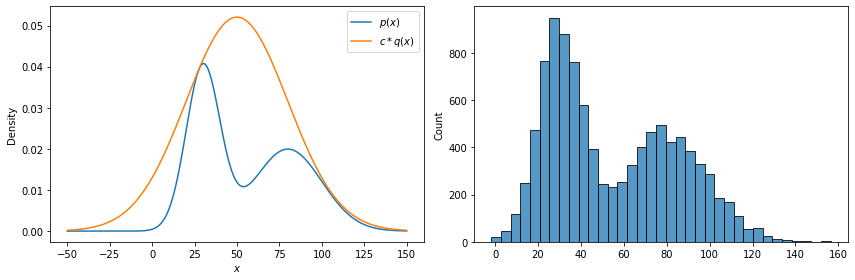

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x, p(x), label = '$p(x)$')
plt.plot(x, c*q.pdf(x), label = '$c*q(x)$')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.histplot(samples)
plt.tight_layout()